In [1]:
# imports and constants
import pyloudnorm as pyln
import librosa
from IPython.display import Audio
import pyloudnorm as pyln
import pickle
import numpy as np
import os
import random
import gc
from pprint import pprint
import numpy


# constants
DATA_PATHS_EMOTIONS = r'C:\Users\miche\spyder_10jan2024\folders_samples_spec_ecc\guitar_emotion_info\listening-test-results/listen_audio_paths_emotions.pickle'
files_each_emotion = [96, 116, 77, 98]   # ['aggressive', 'relaxed', 'happy', 'sad']
SAMPLING_RATE = 22050
SEGMENT_LENGTH = SAMPLING_RATE * 3  # 66150
EMOTIONS = ['aggressive', 'relaxed', 'happy', 'sad']


# functions
def normalize_loudness(audio_file, sr, loudness_level=-26, verbose=False):
    # create BS.1770 meter and get audio loudness
    meter = pyln.Meter(sr)
    loudness = meter.integrated_loudness(audio_file)
    # loudness normalize to -26 dB LUFS
    loudness_normalized_audio = pyln.normalize.loudness(audio_file, loudness, loudness_level)
    if verbose:
        print(f"\nDETAILS OF normalized_audio FUNCTION\n"
              f"- old loudness: {loudness}\n"
              f"- new loudness: {meter.integrated_loudness(loudness_normalized_audio)}")
    return loudness_normalized_audio

In [2]:
with open(DATA_PATHS_EMOTIONS, 'rb') as f:
    data = pickle.load(f)

In [3]:
import os

def update_path(old_path, new_base_path):

    # get subpath strating from 'guitar_emotions'
    parts = old_path.replace('\\','/').split('guitar_emotions', 1)
    if len(parts) != 2:
        raise ValueError(f"'guitar_emotions' not found in path: {old_path}")

    sub_path = parts[1].lstrip('/\\')
    # build new path
    new_path = os.path.join(new_base_path, 'guitar_emotions', sub_path)
    return new_path
        

old = r'C:/Users/miche/Desktop/guitar_emotions\\aggressive\\name_audio_file.wav'
new_base = r'C:\Users\miche\spyder_10jan2024\folders_samples_spec_ecc'

update_path(old, new_base)

# get x and y converting the path to the new folder
X = []
y = []
for file_path, emotion in zip(data['audio_path'], data['emotion']):

    updated_path = update_path(file_path, new_base)
    X.append(updated_path)
    y.append(emotion) 


In [4]:
# make train test split
from sklearn.model_selection import GroupShuffleSplit, StratifiedGroupKFold
import os

# estrai nome del musicista dal path
def extracet_musician_name(path):
    filename = os.path.basename(path)
    parts  = filename.split('_')
    return parts[-3] if len(parts) >= 3 else 'unknown'

# lista con nome del musicista per ogni file
groups = [extracet_musician_name(p) for p in X]


# OLD
#splitter = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
#train_idx, test_idx = next(splitter.split(X, y, groups=groups))

# NEW
splitter = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=1)
train_idx, test_idx = next(splitter.split(X, y, groups=groups))


# creare i set
X_train = [X[i] for i in train_idx]
y_train = [y[i] for i in train_idx]
X_test = [X[i] for i in test_idx]
y_test = [y[i] for i in test_idx]


# verifica che sia stato diviso correttamente - niente sovrapposizioni
train_musicians = set(extracet_musician_name(X[i]) for i in train_idx)
test_musicians = set(extracet_musician_name(X[i]) for i in test_idx)
overlap = train_musicians & test_musicians

print('train_set:', train_musicians, end='\n\n')
print('test_set:', test_musicians, end='\n\n')
print('overlap:', overlap)


train_set: {'TizBol', 'NicLat', 'AntDel', 'AngLoi', 'TomCan', 'MasChi', 'SteRom', 'palm', 'FilMel', 'DavRos', 'GioAcq', 'OweWin', 'AdoLaV', 'AntPao', 'CesSam', 'GiaFer', 'SamLor', 'LucFra', 'TizCam', 'AleMar', 'LucTur', 'pick', 'FedCer', 'FraBen', 'SimArm', 'MarPia'}

test_set: {'NicCon', 'GioDic', 'SalOli', 'MatRig', 'DavBen', 'ValFui'}

overlap: set()


In [5]:
import librosa
import numpy as np
import os
import pickle

import matplotlib.pyplot as plt
import librosa.display

# Constants
SAMPLING_RATE = 22050
SEGMENT_DURATION = 3  # seconds
SEGMENT_SAMPLES = SEGMENT_DURATION * SAMPLING_RATE
N_MELS = 128
N_FFT = 2048
HOP_LENGTH = 512
SAVE = True


OVERLAP = 0.75
HOP_LENGTH_SEGM = int(SEGMENT_SAMPLES * (1 - OVERLAP))
print(HOP_LENGTH_SEGM/22050)


def process_audio_file(file_path, label, data_dict):
    
    try:

        y, sr = librosa.load(file_path, sr=SAMPLING_RATE)
        #num_segments = len(y) // SEGMENT_SAMPLES
        max_start = len(y) - SEGMENT_SAMPLES
        num_segments = max_start // HOP_LENGTH_SEGM + 1

        for i in range(num_segments):
            #start = i * SEGMENT_SAMPLES
            start = i * HOP_LENGTH_SEGM
            end = start + SEGMENT_SAMPLES
            segment = y[start:end]

            # get mel spec
            mel = librosa.feature.melspectrogram(y=segment, sr=SAMPLING_RATE, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS)

            mel_db = librosa.power_to_db(mel, ref=np.max)  

            # normalize, set to 0 if signal is zero o near
            if abs( mel_db.max() - mel_db.min() ) < 1e-6:
                mel_db_norm = np.zeros_like(mel_db)
                print("spectrogram set to zero")
            else:
                mel_db_norm = ( mel_db - mel_db.min() ) / ( mel_db.max() - mel_db.min() )

            
            data_dict['spec'].append(mel_db_norm)
            data_dict['label'].append(label)
            data_dict['segment_index'].append(i)
            data_dict['original_path'].append(file_path)

    except Exception as e:
        print(f'error processing {file_path}: {e}')


# --- doing the preprocessing ---

train_data_dict = { 'spec': [], 'label': [], 'segment_index': [], 'original_path': [] }
test_data_dict = { 'spec': [], 'label': [], 'segment_index': [], 'original_path': [] }

for path, label in zip(X_train, y_train):
    process_audio_file(path, label, train_data_dict)

for path, label in zip(X_test, y_test):
    process_audio_file(path, label, test_data_dict)

# save audio files
TRAIN_SPEC_PATH = 'C:\\Users\\miche\\spyder_10jan2024\\folders_samples_spec_ecc\\1__app_emotions\\train_data_dict_XXoverlap.pkl'
TEST_SPEC_PATH = 'C:\\Users\\miche\\spyder_10jan2024\\folders_samples_spec_ecc\\1__app_emotions\\test_data_dict_XXoverlap.pkl'

if SAVE:
    with open(TRAIN_SPEC_PATH, 'wb') as f:
        pickle.dump(train_data_dict, f)
    with open(TEST_SPEC_PATH, 'wb') as f:
        pickle.dump(test_data_dict, f)

print(f"saved {len(train_data_dict['spec'])} segments to {TRAIN_SPEC_PATH}")
print(f"saved {len(test_data_dict['spec'])} segments to {TEST_SPEC_PATH}")

 
#not overlap -> train: 2742 segments, test 674 segments
#75% overlap -> train: 10544 segments, test 2562 segments
#87.5% overlap -> train: 20933 segments, test 5081 segments

0.3749659863945578
spectrogram set to zero
spectrogram set to zero
spectrogram set to zero
saved 20933 segments to C:\Users\miche\spyder_10jan2024\folders_samples_spec_ecc\1__app_emotions\train_data_dict_875overlap.pkl
saved 5081 segments to C:\Users\miche\spyder_10jan2024\folders_samples_spec_ecc\1__app_emotions\test_data_dict_875overlap.pkl


### Classification

In [1]:


# maybe we can delete some of these imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
import gc


import librosa
import os
import keras
from keras.applications import inception_v3
#from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pickle
from keras.utils import load_img, img_to_array



# build and train a CNN
def build_model(input_shape, learning_rate=0.001, classes=4, filters=[16, 16, 16, 16], neurons=32):
    # create model
    model = keras.Sequential()
    # 1st conv layer
    model.add(keras.layers.Conv2D(filters[0], (3, 3), name='conv_1', activation='relu', input_shape=input_shape, padding='same'))
    model.add(keras.layers.MaxPool2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    # 2nd conv layer
    model.add(keras.layers.Conv2D(filters[1], (3, 3), name='conv_2', activation='relu', padding='same'))
    model.add(keras.layers.MaxPool2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    # 3rd conv layer
    model.add(keras.layers.Conv2D(filters[2], (3, 3), name='conv_3', activation='relu', padding='same'))
    model.add(keras.layers.MaxPool2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    # 4th conv layer
    model.add(keras.layers.Conv2D(filters[3], (3, 3), name='conv_4', activation='relu', padding='same'))
    model.add(keras.layers.MaxPool2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # flatten the output and feed into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(neurons, name='dense_1', activation='relu'))
    model.add(keras.layers.Dropout(0.2))
    
    # output layer   
    model.add(keras.layers.Dense(classes, activation='softmax'))
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=["accuracy"])
    
    return model



# with early stopping
def train(model_, X_train, y_train, X_test, y_test, epochs, batch_size, patience=5):

    # for early stopping
    count = 0
    best_test_accuracy = 0
    
    train_accuracies = []
    test_accuracies = []
    
    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        print('epoch:', epoch+1)
        model_.fit(X_train, y_train, epochs=1, batch_size=batch_size, shuffle=True)

        train_loss, train_accuracy =  model_.evaluate(X_train, y_train, verbose=0)
        train_accuracies.append(train_accuracy)
        train_losses.append(train_loss)

        test_loss, test_accuracy =  model_.evaluate(X_test, y_test, verbose=0)
        test_accuracies.append(test_accuracy)
        test_losses.append(test_loss)
        
        print(f'- train acc: {train_accuracy},  - test acc: {test_accuracy}')   

        
        if test_accuracy < best_test_accuracy:            
            count+=1

            print(f'No improvement ({count}/{patience})')
            if count >= patience: 
                print('Early stopping triggered')
                break

        else:
            best_test_accuracy = test_accuracy
            count=0
        
        #tf.keras.backend.clear_session()
        gc.collect()

    return train_accuracies, train_losses, test_accuracies, test_losses



# GPT vesrion with some improvements: such as putting the weight of the best model --------- test and re-write
import gc
import numpy as np

def train(model_, X_train, y_train, X_test, y_test, epochs, batch_size, patience=5):
    count = 0
    best_test_accuracy = 0.0
    best_weights = None

    train_accuracies, test_accuracies = [], []
    train_losses, test_losses = [], []

    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}')
        model_.fit(X_train, y_train, epochs=1, batch_size=batch_size, shuffle=True, verbose=1)

        train_loss, train_accuracy = model_.evaluate(X_train, y_train, verbose=0)
        test_loss, test_accuracy = model_.evaluate(X_test, y_test, verbose=0)

        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print(f'- train acc: {train_accuracy:.4f}, test acc: {test_accuracy:.4f}')

        if test_accuracy <= best_test_accuracy:
            count += 1
            print(f'No improvement ({count}/{patience})')
            if count >= patience:
                print('Early stopping triggered.')
                if best_weights:
                    model_.set_weights(best_weights)  # Restore best weights
                break
        else:
            best_test_accuracy = test_accuracy
            best_weights = model_.get_weights()
            count = 0

        gc.collect()

    return train_accuracies, train_losses, test_accuracies, test_losses
# -------------------------------------------------------------------------------------------------------------------


def plot_acc_loss(train_acc, train_loss, test_acc, test_loss, Print=False, save_path=False):
    fig, axs = plt.subplots(2)
    # create accuracy sublpot
    axs[0].plot(train_acc, label="train accuracy")
    axs[0].plot(test_acc, label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    #axs[0].set_title("Accuracy eval")
    axs[0].set_xticks(np.arange(0, len(train_acc)), np.arange(1, len(train_acc)+1))

    # create error sublpot
    axs[1].plot(train_loss, label="train error")
    axs[1].plot(test_loss, label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    #axs[1].set_title("Error eval")
    axs[1].set_xticks(np.arange(0, len(train_acc)), np.arange(1, len(train_acc)+1))



C:\Users\miche\anaconda3\envs\py310\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:

#TRAIN_SPEC_PATH = 'C:\\Users\\miche\\spyder_10jan2024\\folders_samples_spec_ecc\\1__app_emotions\\train_data_dict.pkl'
#TEST_SPEC_PATH = 'C:\\Users\\miche\\spyder_10jan2024\\folders_samples_spec_ecc\\1__app_emotions\\test_data_dict.pkl'

#TRAIN_SPEC_PATH = 'C:\\Users\\miche\\spyder_10jan2024\\folders_samples_spec_ecc\\1__app_emotions\\train_data_dict_50overlap.pkl'
#TEST_SPEC_PATH = 'C:\\Users\\miche\\spyder_10jan2024\\folders_samples_spec_ecc\\1__app_emotions\\test_data_dict_50overlap.pkl'

TRAIN_SPEC_PATH = 'C:\\Users\\miche\\spyder_10jan2024\\folders_samples_spec_ecc\\1__app_emotions\\train_data_dict_75overlap.pkl'
TEST_SPEC_PATH = 'C:\\Users\\miche\\spyder_10jan2024\\folders_samples_spec_ecc\\1__app_emotions\\test_data_dict_75overlap.pkl'

##TRAIN_SPEC_PATH = 'C:\\Users\\miche\\spyder_10jan2024\\folders_samples_spec_ecc\\1__app_emotions\\train_data_dict_875overlap.pkl'
##TEST_SPEC_PATH = 'C:\\Users\\miche\\spyder_10jan2024\\folders_samples_spec_ecc\\1__app_emotions\\test_data_dict_875overlap.pkl'

# forse per il test dovrei usare sempre quella senza ovelap? i chitarristi in teoria sono gli stessi nel test set

with open(TRAIN_SPEC_PATH, 'rb') as f:
    data_train = pickle.load(f)
    
with open(TEST_SPEC_PATH, 'rb') as f:
    data_test = pickle.load(f)

In [3]:
from sklearn.model_selection import StratifiedGroupKFold
import numpy as np

# TRAIN
# get data
X = np.array(data_train['spec'])[..., np.newaxis]
y = np.array(data_train['label'])
groups = np.array(data_train['original_path'])

# create split
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=0)
for train_idx, val_idx in sgkf.split(X, y, groups):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    break

# add 3 channels
X_train = np.repeat(X_train, 3, axis=-1)
X_val = np.repeat(X_val, 3, axis=-1)
print('train distrib', np.bincount(y_train))
print('val distrib', np.bincount(y_val))
# -------------------------------------------------------------------

# TEST
X_test = np.array(data_test['spec'])[..., np.newaxis]
y_test = np.array(data_test['label'])
X_test = np.repeat(X_test, 3, axis=-1)
# -------------------------------------------------------------------

# verify label distribution
print('\ntrain + validation distribution', np.bincount(y))
print('test distribution', np.bincount(y_test))


train distrib [1821 2886 1466 2355]
val distrib [516 550 458 492]

train distribution [2337 3436 1924 2847]
test distribution [558 791 552 661]


In [68]:
'''
# constants
BATCH_SIZE = 32
EPOCHS = 20
CLASSES = 4
FILTERS = [8, 8, 16, 16]
#FILTERS = [16, 16, 16, 16]
NEURONS = 32
LEARNING_RATE = 0.0001

tf.keras.backend.clear_session()
gc.collect()

model = build_model(input_shape =  X_test.shape[1:], learning_rate=LEARNING_RATE, classes=CLASSES, filters=FILTERS, neurons=NEURONS)
model.summary()

# train the model
train_accuracies, train_losses, test_accuracies, test_losses = train(model, X_train, y_train, X_val, y_val, epochs=EPOCHS, batch_size=BATCH_SIZE, patience=3)

# plot accuracy and loss
plot_acc_loss(train_accuracies, train_losses, test_accuracies, test_losses, Print=False, save_path=False)
'''

'\n# constants\nBATCH_SIZE = 32\nEPOCHS = 20\nCLASSES = 4\nFILTERS = [8, 8, 16, 16]\n#FILTERS = [16, 16, 16, 16]\nNEURONS = 32\nLEARNING_RATE = 0.0001\n\ntf.keras.backend.clear_session()\ngc.collect()\n\nmodel = build_model(input_shape =  X_test.shape[1:], learning_rate=LEARNING_RATE, classes=CLASSES, filters=FILTERS, neurons=NEURONS)\nmodel.summary()\n\n# train the model\ntrain_accuracies, train_losses, test_accuracies, test_losses = train(model, X_train, y_train, X_val, y_val, epochs=EPOCHS, batch_size=BATCH_SIZE, patience=3)\n\n# plot accuracy and loss\nplot_acc_loss(train_accuracies, train_losses, test_accuracies, test_losses, Print=False, save_path=False)\n'

In [4]:
# use a more conventional way of training

tf.keras.backend.clear_session()
gc.collect()


# constants
CLASSES = 4

BATCH_SIZE = 32
EPOCHS = 30
FILTERS = [8, 8, 16, 16]
NEURONS = 32
LEARNING_RATE = 0.0001

PATIENCE = 5

tf.keras.backend.clear_session()
gc.collect()

model = build_model(input_shape =  X_test.shape[1:], learning_rate=LEARNING_RATE, classes=CLASSES, filters=FILTERS, neurons=NEURONS)
model.summary()

from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=PATIENCE,
    restore_best_weights=True,
    verbose=2
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    callbacks=[early_stopping]
)





Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 128, 130, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 65, 8)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 64, 65, 8)        32        
 ormalization)                                                   
                                                                 
 conv_2 (Conv2D)             (None, 64, 65, 8)         584       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 33, 8)        0         
 2D)                                                             
                                                        

In [5]:
model.evaluate(X_test, y_test)

81/81 [==============================] - 2s 14ms/step - loss: 1.0271 - accuracy: 0.5320


[1.0271273851394653, 0.5320062637329102]

In [83]:
SAVE_MODEL_PATH = r'C:\Users\miche\spyder_10jan2024\folders_samples_spec_ecc\1__app_emotions\models\for_heatmap\patience_5_validation_set\model_75_over_xx.h5'
#model.save(SAVE_MODEL_PATH)


### prediction on different segments of an entire guitar execution

In [30]:
# imports and constants
import pyloudnorm as pyln
import librosa
from IPython.display import Audio
import pyloudnorm as pyln
import pickle
import numpy as np
import os
import random
import gc
from pprint import pprint
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

Playing segment 0 


1/1 [==============================] - 0s 381ms/step
Playing segment 1 


1/1 [==============================] - 0s 59ms/step
Playing segment 2 


1/1 [==============================] - 0s 52ms/step
Playing segment 3 


1/1 [==============================] - 0s 87ms/step
Playing segment 4 


1/1 [==============================] - 0s 161ms/step
final prediction: aggressive, true label: aggressive


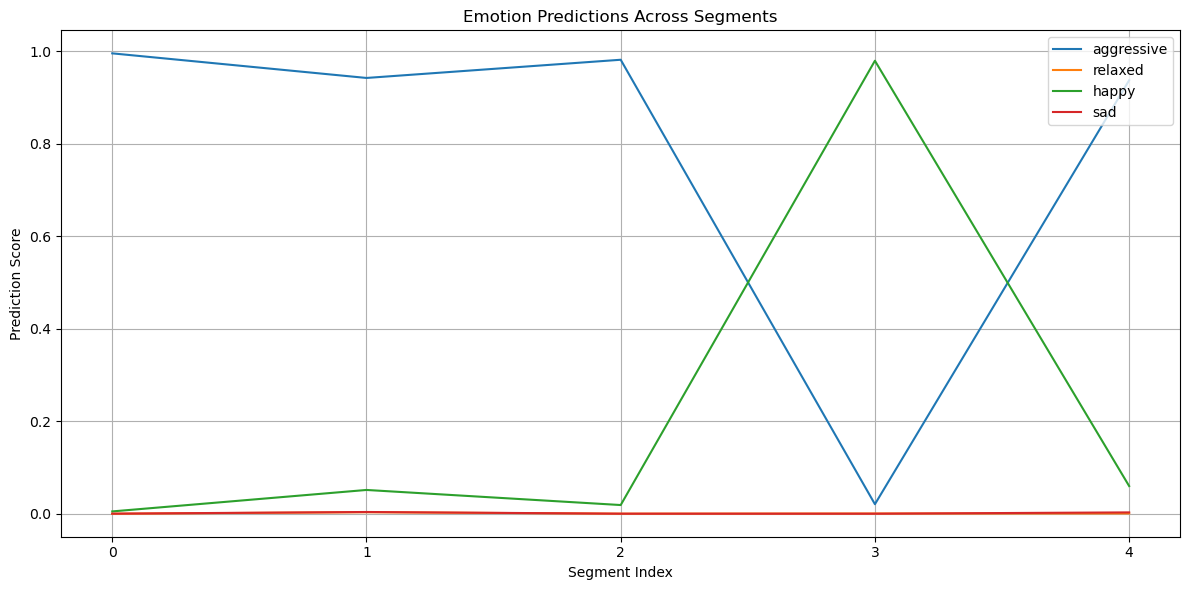

In [33]:

# load test set to get the original path
TEST_SPEC_PATH = 'C:\\Users\\miche\\spyder_10jan2024\\folders_samples_spec_ecc\\1__app_emotions\\test_data_dict.pkl'
#SAVE_MODEL_PATH = r'C:\Users\miche\spyder_10jan2024\folders_samples_spec_ecc\1__app_emotions\models\model_acc52.h5'
#SAVE_MODEL_PATH = r'C:\Users\miche\spyder_10jan2024\folders_samples_spec_ecc\1__app_emotions\models\model_acc54_75overlap.h5'


# try 75% overlap
#TEST_SPEC_PATH = 'C:\\Users\\miche\\spyder_10jan2024\\folders_samples_spec_ecc\\1__app_emotions\\train_data_dict_75overlap.pkl'
#SAVE_MODEL_PATH = r'C:\Users\miche\spyder_10jan2024\folders_samples_spec_ecc\1__app_emotions\models\model_acc54_75overlap.h5'

EMOTIONS = ['aggressive', 'relaxed', 'happy', 'sad']

SAMPLING_RATE = 22050
SEGMENT_DURATION = 3  # seconds
SEGMENT_SAMPLES = SEGMENT_DURATION * SAMPLING_RATE
N_MELS = 128
N_FFT = 2048
HOP_LENGTH = 512

# option 1 - advance of a fraction of the segment
OVERLAP = 0  # 75% overlap
HOP_LENGTH_SEGM = int(SEGMENT_SAMPLES * (1 - OVERLAP))

# option 2 - advance with an arbitrary number of samples
#HOP_LENGTH_SEGM = 1000
#SEGM_DIVISION = SEGMENT_SAMPLES // HOP_LENGTH_SEGM

INDEX = 124

# plot function
def plot_prediction_each_segment(predictions_):
    plt.figure(figsize=(12, 6))
    for emotion in EMOTIONS:
        plt.plot(predictions_['segment_index'], predictions_[emotion], label=emotion)

    plt.xlabel("Segment Index")
    plt.ylabel("Prediction Score")
    plt.title("Emotion Predictions Across Segments")
    plt.legend(loc="upper right")
    plt.grid(True)

    # Set integer ticks on x-axis
    segment_indices = predictions_['segment_index']
    plt.xticks(ticks=range(min(segment_indices), max(segment_indices) + 1))
    plt.tight_layout()
    plt.show()



# get mel log mel spec and normalize
def get_input_sample(segment_):
    mel = librosa.feature.melspectrogram(y=segment_, sr=SAMPLING_RATE, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    mel_db_norm = ( mel_db - mel_db.min() ) / ( mel_db.max() - mel_db.min() )  # normalize 0-1

    # add rgb channels and expand dims
    mel_rgb = np.repeat(mel_db_norm[..., np.newaxis], 3, axis=-1)  # added 3 channels
    return np.expand_dims(mel_rgb, axis=0)




def song_prediction(data_test_, model_, index=100):

    # dictionary to save predictions    
    predictions = { 'aggressive': [], 'relaxed': [], 'happy':  [], 'sad': [], 'segment_index': [] }

    # load audio file
    y, sr = librosa.load(data_test_['original_path'][index], sr=SAMPLING_RATE)
    label = data_test_['label'][index]
    
    
    # num_segments = len(y) // HOP_LENGTH_SEGM - (SEGM_DIVISION-1)  -> my option
    # gpt option
    max_start = len(y) - SEGMENT_SAMPLES
    num_segments = max_start // HOP_LENGTH_SEGM + 1
    
    for i in range(num_segments):

        start = i * HOP_LENGTH_SEGM        
        end = start + SEGMENT_SAMPLES
        segment = y[start:end]                          

        # display each specific segment
        print(f'Playing segment {i} ')
        display(Audio(segment, rate=sr))

        # get spectrogram and prepar
        mel_rgb_batch = get_input_sample(segment)
        prediction = model_.predict(mel_rgb_batch)[0]          # predict      

        # save information
        for emotion, score in zip(EMOTIONS, prediction):
            predictions[emotion].append(score)
        predictions['segment_index'].append(i)

    # get the overall prediction
    emotion_totals = {emotion: sum(predictions[emotion]) for emotion in EMOTIONS}  # sum segment
    final_prediction = max(emotion_totals, key=emotion_totals.get)                 # get max

    # print and plot
    print(f'final prediction: {final_prediction}, true label: {EMOTIONS[label]}')   
    plot_prediction_each_segment(predictions)


# 123 - aggressive, easy
# 124 - aggressive, but segment 7 says happy - interesting sample
# 300 - relaxed, not so clear
# 222 - figo qui il modello sbaglia, ma sembra ragionare bene direi, c'è punto solo relax, solo happy, super confusione fra i 4



# load test set - that has the paths saved
with open(TEST_SPEC_PATH, 'rb') as f:
    data_test = pickle.load(f)

# load model
model = load_model(SAVE_MODEL_PATH)

# song prediction for each segment
song_prediction(data_test, model, INDEX)

# listen to the different segments of the song


### Accuracy song level

In [2]:
# imports and constants
import pickle
import numpy as np
import os
import gc
from pprint import pprint
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

TEST_SPEC_PATH = 'C:\\Users\\miche\\spyder_10jan2024\\folders_samples_spec_ecc\\1__app_emotions\\test_data_dict.pkl'
#TEST_SPEC_PATH = 'C:\\Users\\miche\\spyder_10jan2024\\folders_samples_spec_ecc\\1__app_emotions\\test_data_dict_50overlap.pkl'
#TEST_SPEC_PATH = 'C:\\Users\\miche\\spyder_10jan2024\\folders_samples_spec_ecc\\1__app_emotions\\test_data_dict_75overlap.pkl'
SAVE_MODEL_PATH = r'C:\Users\miche\spyder_10jan2024\folders_samples_spec_ecc\1__app_emotions\models\for_heatmap\patience_5_validation_set\model_75_over_53.h5'


# load test set - that has the paths saved
with open(TEST_SPEC_PATH, 'rb') as f:
    data_test = pickle.load(f)

# load model
model = load_model(SAVE_MODEL_PATH)

# test:no over, model:<no over 54 %
# test:50, model:75 > 60%
# test:no over, model:75 > 64%

In [3]:
# riscritta da zero. non propriamente il mio stile perchè avrei forse usato un dictionary con 'path', 'label', 'pred', 'label', 'segm_pred'
# qui invece come risultato ottengo un dictionary che ha come key il 'path' e contine una lista con i risultati

# song_predictions['path_1'] = (2,     2,   [6, 1.2, 0.71, 1],  [ [], [], [] ,..])
# song_predictions['path_2'] = (true, pred, softmax summation, softmax for each segment)
# ...


from collections import defaultdict
import numpy as np
import os

def compute_song_level_accuracy_softmax_avg(model, data_dict, verbose=False):

    """
    Computes song-level accuracy via softmax output summation over segments.

    Args:
        model: Trained CNN model.
        data_dict: Dict with keys 'spec', 'label', 'original_path', 'segment_index'
        verbose: Print per-song prediction results if True.

    Returns:
        song_accuracy: float
        song_predictions: dict mapping song_path to (true_label, predicted_label, summed_softmax, segment_preds)
    """

    song_segments = defaultdict(list)
    song_labels = {}

    for spec, label, path, seg_idx in zip(data_dict['spec'], data_dict['label'], data_dict['original_path'], data_dict['segment_index']):

        song_segments[path].append((seg_idx, spec))   #  m. esempio: song_segments['path_1'] = [(0, segm0), (1, segm1), (2, segm2)]
        song_labels[path] = label                     #  m. esempio:  song_labels['path_1'] = 3

    correct = 0
    total = 0
    song_predictions = {}

    for song_path, seg_data in song_segments.items():

        segment_specs = [spec for _, spec in seg_data]    # m. I ignored the sorting of segments, they are already sorted
        segment_array = np.array(segment_specs)[..., np.newaxis]
        segment_array = np.repeat(segment_array, 3, axis=-1)
        
        preds = model.predict(segment_array, verbose=0)   # m. get prediciton for bacth od segments -> [[.2, .3, .5, .0], [...], [...]]
        summed_softmax = np.sum(preds, axis=0)            # sum softmax prediciton of all the segments
        pred_label = np.argmax(summed_softmax)
        true_label = song_labels[song_path]

        if verbose: print(f'song: {os.path.basename(song_path)} | True {true_label} | Pred {pred_label} | segments: {len(segment_specs)}')

        song_predictions[song_path] = (true_label, pred_label, summed_softmax, preds.tolist())  # save prediction and softmax output

        if pred_label == true_label:
            correct+=1
        total+=1

    accuracy = correct / total if total > 0 else 0.0
    print(f'Song-level Accuracy (softmax sum): {accuracy:.4f} ({correct}/{total})')
    
    return accuracy, song_predictions
    
accuracy, song_predictions = compute_song_level_accuracy_softmax_avg(model, data_test, verbose=False)

Song-level Accuracy (softmax sum): 0.5357 (45/84)


Plot saved to: C:\Users\miche\spyder_10jan2024\folders_samples_spec_ecc\1__app_emotions\histograms\emotion_histograms.png


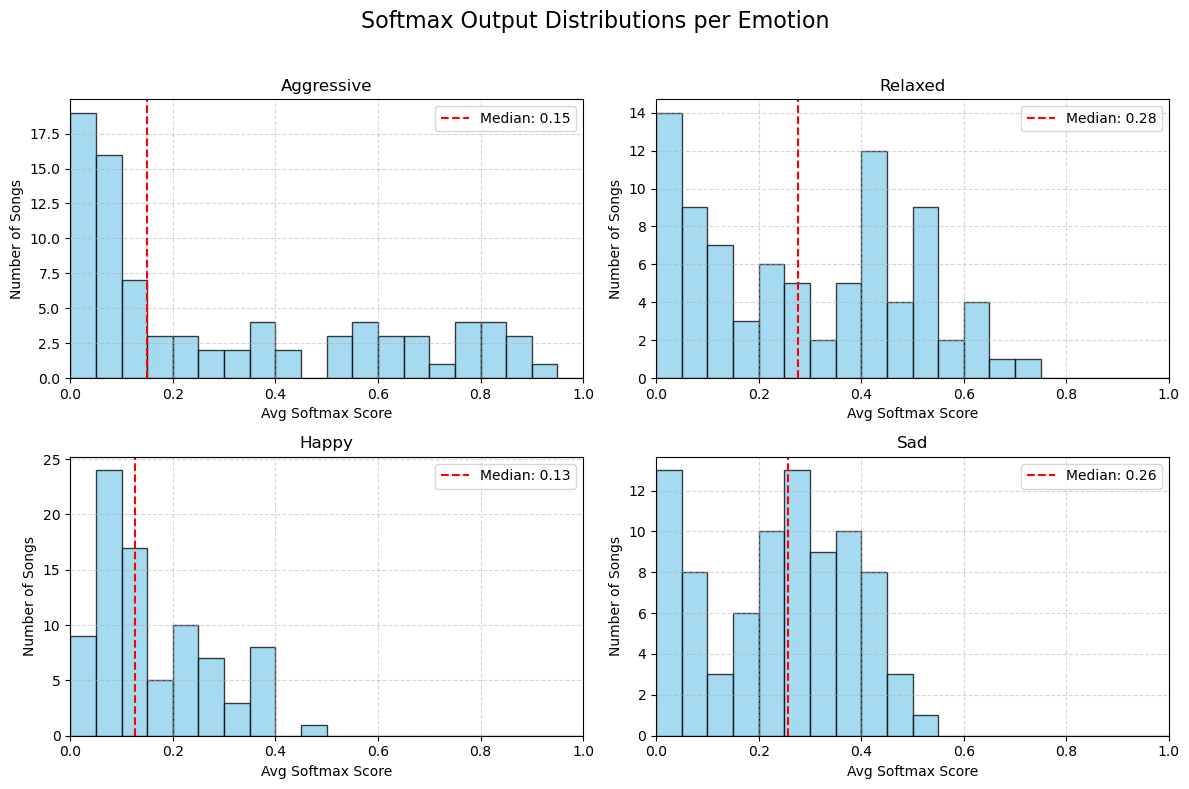

In [30]:
import matplotlib.pyplot as plt
import numpy as np

def plot_emotion_distributions_subplots(song_predictions, emotions, save_path=None, num_bins=20):
    """
    Create a 2x2 subplot of softmax score histograms per emotion, with fixed bin width and range.
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.flatten()

    bin_edges = np.linspace(0, 1, num_bins + 1)  # consistent bins for all plots

    for i, emotion in enumerate(emotions):
        outputs = []
        for _, (_, _, summed_softmax, segment_preds) in song_predictions.items():
            avg_softmax = np.array(summed_softmax) / len(segment_preds)
            outputs.append(avg_softmax[i])

        median_val = np.median(outputs)

        ax = axes[i]
        ax.hist(outputs, bins=bin_edges, alpha=0.75, color='skyblue', edgecolor='black')
        ax.axvline(median_val, color='red', linestyle='--', label=f'Median: {median_val:.2f}')
        ax.set_title(f'{emotion.capitalize()}')
        ax.set_xlabel('Avg Softmax Score')
        ax.set_ylabel('Number of Songs')
        ax.set_xlim(0, 1)
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.legend()

    plt.suptitle('Softmax Output Distributions per Emotion', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to: {save_path}")

    plt.show()

# Usage
EMOTIONS = ['aggressive', 'relaxed', 'happy', 'sad']
save_path = r'C:\Users\miche\spyder_10jan2024\folders_samples_spec_ecc\1__app_emotions\histograms\emotion_histograms.png'
plot_emotion_distributions_subplots(song_predictions, EMOTIONS, save_path=save_path, num_bins=20)


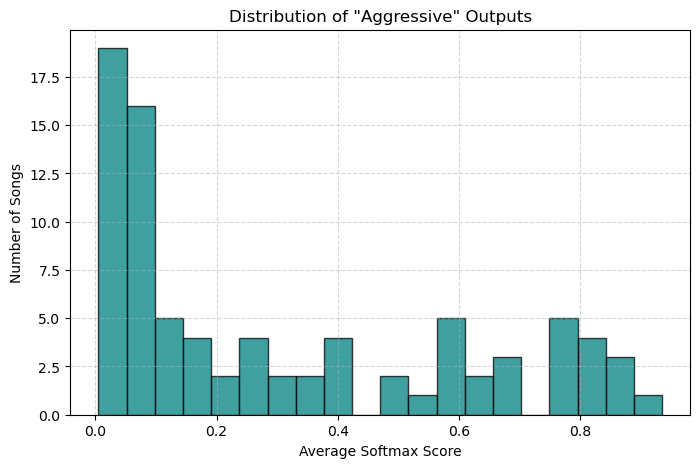

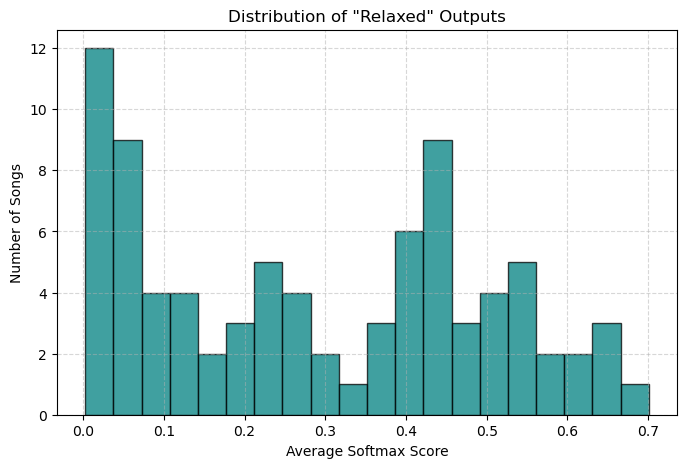

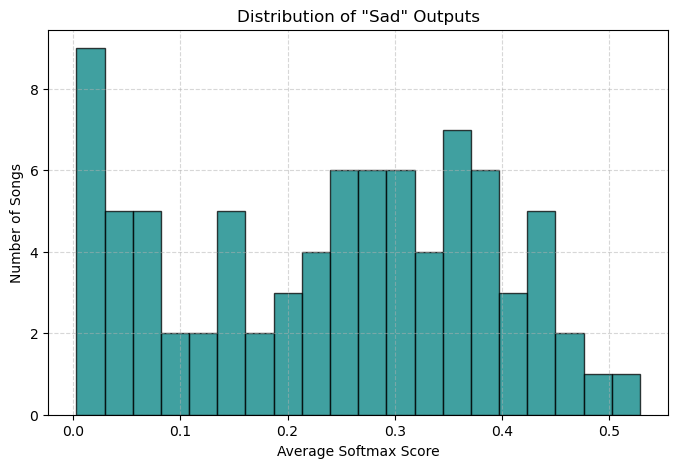

In [20]:
import matplotlib.pyplot as plt
import numpy as np

def plot_emotion_output_distribution(song_predictions, emotion_index, emotion_name=None):

    """
    Plot a histogram of the average softmax output for a specific emotion class across all songs.

    Args:
        song_predictions: dict mapping song_path to (true_label, pred_label, summed_softmax, segment_preds)
        emotion_index: int, index of the emotion in the softmax vector
        emotion_name: str, optional name to use in title
    """
    outputs = []

    for _, (_, _, summed_softmax, segment_preds) in song_predictions.items():
        avg_softmax = np.array(summed_softmax) / len(segment_preds)
        outputs.append(avg_softmax[emotion_index])

    plt.figure(figsize=(8, 5))
    plt.hist(outputs, bins=20, alpha=0.75, color='teal', edgecolor='black')
    plt.title(f'Distribution of "{emotion_name or f"Class {emotion_index}"}" Outputs')
    plt.xlabel('Average Softmax Score')
    plt.ylabel('Number of Songs')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

EMOTIONS = ['aggressive', 'relaxed', 'happy', 'sad']

for i, emotion in enumerate(EMOTIONS):
    plot_emotion_output_distribution(song_predictions, emotion_index=i, emotion_name=emotion.capitalize())
    

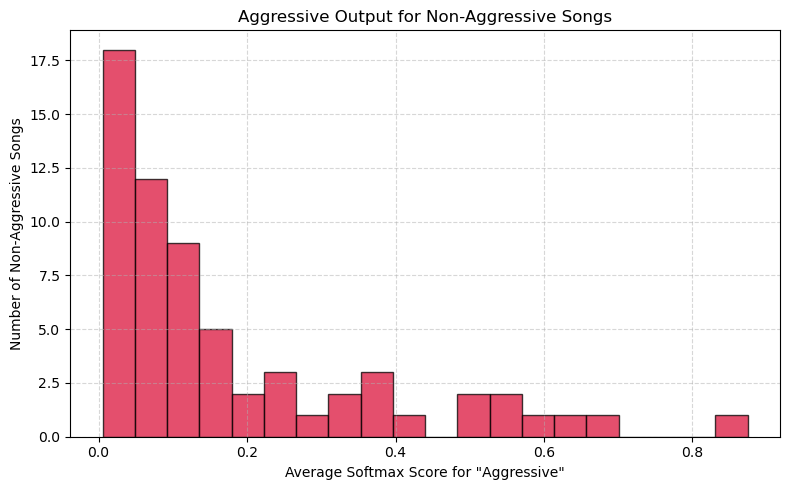

In [10]:
def plot_aggressive_output_for_non_aggressive_songs(song_predictions):
    """
    Plot histogram of the model's 'aggressive' softmax output for all songs
    whose true label is NOT aggressive (i.e., false positives and background activation).
    """
    EMOTION_INDEX = 0  # aggressive
    aggressive_outputs = []

    for _, (true_label, pred_label, summed_softmax, segment_preds) in song_predictions.items():
        if true_label != EMOTION_INDEX:
            avg_softmax = np.array(summed_softmax) / len(segment_preds)
            aggressive_outputs.append(avg_softmax[EMOTION_INDEX])

    plt.figure(figsize=(8, 5))
    plt.hist(aggressive_outputs, bins=20, alpha=0.75, color='crimson', edgecolor='black')
    plt.title('Aggressive Output for Non-Aggressive Songs')
    plt.xlabel('Average Softmax Score for "Aggressive"')
    plt.ylabel('Number of Non-Aggressive Songs')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

plot_aggressive_output_for_non_aggressive_songs(song_predictions)


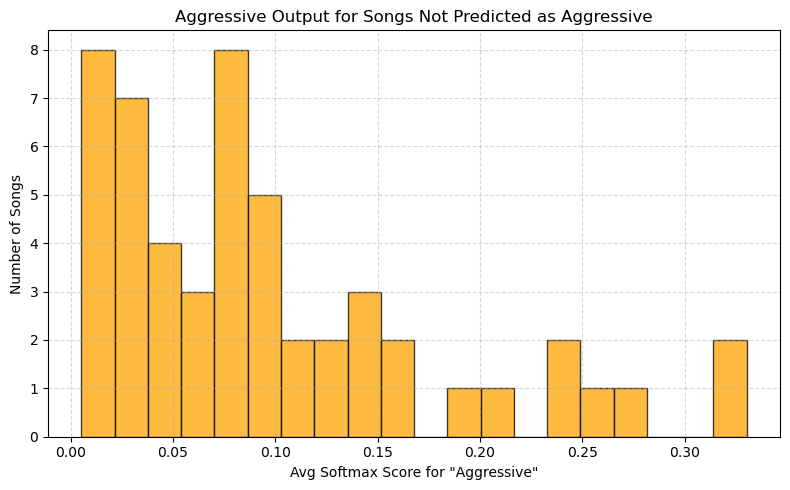

In [12]:
def plot_aggressive_output_for_non_predicted_aggressive_songs(song_predictions):
    """
    Plot histogram of the model's 'aggressive' softmax output for all songs
    that were NOT classified as aggressive.
    """
    EMOTION_INDEX = 0  # aggressive
    outputs = []

    for _, (_, pred_label, summed_softmax, segment_preds) in song_predictions.items():
        if pred_label != EMOTION_INDEX:
            avg_softmax = np.array(summed_softmax) / len(segment_preds)
            outputs.append(avg_softmax[EMOTION_INDEX])

    plt.figure(figsize=(8, 5))
    plt.hist(outputs, bins=20, alpha=0.75, color='orange', edgecolor='black')
    plt.title('Aggressive Output for Songs Not Predicted as Aggressive')
    plt.xlabel('Avg Softmax Score for "Aggressive"')
    plt.ylabel('Number of Songs')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


plot_aggressive_output_for_non_predicted_aggressive_songs(song_predictions)

In [4]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
SAVE=True

EMOTIONS = ['aggressive', 'relaxed', 'happy', 'sad']

y_true = [v[0] for v in song_predictions.values()]  # labels
y_pred = [v[1] for v in song_predictions.values()]  # predictions

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=EMOTIONS)
# Display it with labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=EMOTIONS)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix (Song-Level Emotion Prediction)')
plt.xticks(rotation=45)
plt.tight_layout()

if SAVE:
    save_path = r'C:\Users\miche\spyder_10jan2024\folders_samples_spec_ecc\1__app_emotions\models\for_heatmap\conf_matrix\confusion_matrix.png'
    plt.savefig(save_path, dpi=300, bbox_inches='tight')

plt.show()

In [22]:
a = [9,8,7,6,1,2,35]

In [38]:
def print_simple_song_preds(song_predictions, confidence_rule='segment_average'):
    '''
    Print each song's true label, predicted label, whether the prediction was correct,
    and a confidence score based on the specified confidence_rule:
    
    - 'simple_normalization': (top1 - top2) / top1
    - 'segment_average': top1 - top2 of average softmax over segments
    '''
    for path, (true_label, pred_label, summed_softmax, segment_preds) in song_predictions.items():
        song_name = os.path.basename(path)
        status = '✅' if true_label == pred_label else '❌'

        # Compute the confidence score based on the selected rule
        softmax_array = np.array(summed_softmax)
        
        if confidence_rule == 'simple_normalization':
            best_two = np.sort(softmax_array)[-2:]
            top1, top2 = best_two[1], best_two[0]
            confidence_score = (top1 - top2) / top1 if top1 > 0 else 0

        elif confidence_rule == 'segment_average':
            num_segments = len(segment_preds)
            avg_softmax = softmax_array / num_segments
            best_two = np.sort(avg_softmax)[-2:]
            top1, top2 = best_two[1], best_two[0]
            confidence_score = top1 - top2

        else:
            raise ValueError(f"Unsupported confidence_rule: {confidence_rule}")
        
        print(f'{song_name:65} | True: {true_label:<5} Pred: {pred_label:<5} {status} | Confidence: {confidence_score:.2f}')


print_simple_song_preds(song_predictions, confidence_rule='simple_normalization')


13_aggressive_i1_steelstring-guitar_DavBen_pick_20200623.wav      | True: 0     Pred: 0     ✅ | Confidence: 0.80
14_aggressive_i2_steelstring-guitar_DavBen_pick_20200623.wav      | True: 0     Pred: 0     ✅ | Confidence: 0.82
15_aggressive_i3_steelstring-guitar_DavBen_pick_20200623.wav      | True: 0     Pred: 0     ✅ | Confidence: 0.89
212_aggressive_i1_classical-guitar_SalOli_fingers_20200714.wav    | True: 3     Pred: 0     ❌ | Confidence: 0.22
213_aggressive_i2_classical-guitar_SalOli_pick_20200714.wav       | True: 0     Pred: 0     ✅ | Confidence: 0.70
214_aggressive_i3_classical-guitar_SalOli_pick_20200714.wav       | True: 0     Pred: 0     ✅ | Confidence: 0.41
25_aggressive_i1_classical-guitar_DavBen_fingers_20200526.wav     | True: 0     Pred: 0     ✅ | Confidence: 0.34
26_aggressive_i2_classical-guitar_DavBen_pick_20200526.wav        | True: 0     Pred: 0     ✅ | Confidence: 0.85
27_aggressive_i3_classical-guitar_DavBen_pick_20200526.wav        | True: 0     Pred: 0     ✅ | 

In [78]:
import matplotlib.pyplot as plt
import numpy as np

train_overlaps = [0, 50, 75]
test_overlaps = [0, 50, 75]

accuracies = np.array([
    [50.00, 46.43, 53.57],    # 0% on test
    [48.81, 51.19, 54.76],    # 50% on test
    [44.05, 52.38, 54.76],    # 75% on test
])

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(accuracies, cmap='Blues')

vmax = np.max(accuracies)


for i in range(len(test_overlaps)):
    for j in range(len(train_overlaps)):
        val = accuracies[i, j]
        color = "white" if val > vmax * 0.97 else "black"
        ax.text(j, i, f"{val:.2f}", ha="center", va="center", color=color)

ax.set_xticks(np.arange(len(train_overlaps)))
ax.set_yticks(np.arange(len(test_overlaps)))
ax.set_xticklabels(train_overlaps)
ax.set_yticklabels(test_overlaps)

ax.set_xlabel("Training Overlap (%)")
ax.set_ylabel("Inference/Test Overlap (%)")
ax.set_title("Accuracy Heatmap")

cbar = ax.figure.colorbar(im, ax=ax)
cbar.set_label("Accuracy (%)")

plt.tight_layout()

# Flip y-axis so 0 is at bottom
ax.invert_yaxis()


# Save the figure as PNG (you can change the path/filename here)
SAVE = False
heat_path = r'C:\Users\miche\spyder_10jan2024\folders_samples_spec_ecc\1__app_emotions\models\for_heatmap\heatmaps\pat5_1round_heatmap_with_validation.png'
if SAVE:
    plt.savefig(heat_path, dpi=300)

plt.show()


